In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import random
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

st = time.time()

In [3]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.backends import cudnn
cudnn.deterministic = True
cudnn.benchmark = False
device = torch.device('cuda') if torch.cuda.is_available() else roech.device('cpu')

In [4]:
from option import get_option, parser
from trainer import Trainer
from utils import save_option
import data_loader
import models

In [5]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
#logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger(__name__)

import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
def set_seed(seed=87):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(87)

In [7]:
from urlnet_utils import *

In [8]:
min_word_freq = 0
max_len_words = 200
max_len_chars = 200
max_len_subwords = 20
delimit_mode = 1
dev_pct = 0.01

In [34]:
emb_dim = 32
l2_reg_lambda = 0.0
emb_mode = 2
filter_size = [3,4,5,6]
batch_size = 128
epochs = 5
lr = 1e-3

In [10]:
from torch.utils.data import Dataset, DataLoader
class mydata(Dataset):
    def __init__(self, word, char, char_seq, Y):
        self.word = word
        self.char = char
        self.char_seq = char_seq
        self.Y = Y
    def __len__(self):
        return len(self.word)
    def __getitem__(self, index):
        word = pad_seq_in_word([self.word[index]], max_len_words)[0]
        char, char_pad = pad_seq([self.char[index]], max_len_words, max_len_subwords, emb_dim)
        char, char_pad = char[0], char_pad[0]
        char_seq = pad_seq_in_word([self.char_seq[index]], max_len_chars)[0]
        label = self.Y[index]
        return (word, char, char_pad, char_seq, label)
    
# train_dataset = mydata(worded_id_x[train], x_train_char, chared_id_x[train], y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# batch = next(iter(train_loader))

In [11]:
urls, labels = read_data("../URLNet/train_10000.txt")

high_freq_words = None
if min_word_freq > 0:
    x1, word_reverse_dict = get_word_vocab(urls, max_len_words, min_word_freq) 
    high_freq_words = sorted(list(word_reverse_dict.values()))
    print("Number of words with freq >={}: {}".format(min_word_freq, len(high_freq_words)))

x, word_reverse_dict = get_word_vocab(urls, max_len_words)
word_x = get_words(x, word_reverse_dict, delimit_mode, urls)
ngramed_id_x, ngrams_dict, worded_id_x, words_dict = ngram_id_x(word_x, max_len_subwords, high_freq_words)
reverse_dict = {words_dict[i]:i for i in words_dict}
chars_dict = ngrams_dict
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Overall Mal/Ben rate: {}/{}".format(np.sum(labels==1), np.sum(labels==0)))

########  shuffle & split  ######

shuffle_idx = np.random.permutation(np.arange(len(labels)))
train, test = prep_train_test(len(labels), dev_pct)
y_train, y_val = labels[train], labels[test]

x_train_char = ngramed_id_x[train]
x_val_char = ngramed_id_x[test]
x_train_word = worded_id_x[train]
x_val_word = worded_id_x[test]
x_train_char_seq = chared_id_x[train]
x_val_char_seq = chared_id_x[test]


print(x_train_word.shape, x_val_word.shape)
print(x_train_char_seq.shape, x_val_char_seq.shape)
print(x_train_char.shape)
print(x_val_char.shape)

11/12/2019 03:32:09 - WARNING - tensorflow -   From /host/Proxy/learning-not-to-learn/urlnet_utils.py:113: VocabularyProcessor.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
11/12/2019 03:32:09 - WARNING - tensorflow -   From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/preprocessing/text.py:154: CategoricalVocabulary.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.categorical_vocabulary) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.
11/12/2019 03:32:09 - WARNING - tensorflow -   From /usr/local/lib/python3.5/dist-packages/tensorflow/contrib/learn/python/learn/preprocessing/text.py:170: tokenizer (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future ver

Finished build vocabulary and mapping to x in 2.553680419921875
Size of word vocabulary: 63443
Processing #url 0
Size of ngram vocabulary: 131
Size of word vocabulary: 51816
Index of <UNKNOWN> word: 104
Overall Mal/Ben rate: 23613/23613
(46754,) (472,)
(46754,) (472,)
(46754,)
(472,)


In [12]:
with open("word_mal_ratio.pkl", "rb") as f:
    word_mal_ratio = pickle.load(f)

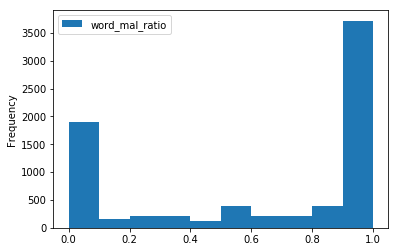

In [13]:
with open("word_mal_ratio2.pkl", "rb") as f:
    word_mal_ratio = pickle.load(f)
with open("char_mal_ratio.pkl", "rb") as f:
    char_mal_ratio = pickle.load(f)


tmp = [word_mal_ratio[i] for i in word_mal_ratio]
tmp = pd.DataFrame({'word_mal_ratio':tmp, 'word':[i for i in word_mal_ratio]})
tmp.plot(kind='hist')

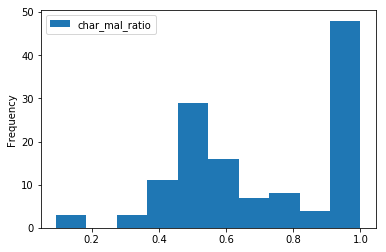

In [14]:
tmp = [char_mal_ratio[i] for i in char_mal_ratio]
tmp = pd.DataFrame({'char_mal_ratio':tmp, 'char':[i for i in char_mal_ratio]})
tmp.plot(kind='hist')

In [15]:
tmp1 = words_dict
tmp2 = ngrams_dict

In [16]:
urls, labels = read_data("../URLNet/val_10000.txt")
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict) 
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Number of testing urls: {}".format(len(labels)))

y_test = np.array(labels)
x_test_char = np.array(ngramed_id_x)
x_test_word = np.array(worded_id_x)
x_test_char_seq = np.array(chared_id_x)
print(x_test_word.shape)
print(x_test_char_seq.shape)
print(x_test_char.shape)

Finished build vocabulary and mapping to x in 0.2773094177246094
Size of word vocabulary: 10884
Index of <UNKNOWN> word: 104
Processing url #0
Number of testing urls: 5248
(5248,)
(5248,)
(5248,)


In [17]:
assert tmp1 == words_dict
assert tmp2 == ngrams_dict

In [18]:
urls, labels = read_data("../taipei/out.csv")#"../URLNet/test_10000.txt"
### balance ###
n_subsample = min((labels==1).sum(), (labels==0).sum())
murl = urls[labels==0]
burl = urls[labels==1]
np.random.shuffle(murl)
np.random.shuffle(burl)
urls = np.concatenate([murl[:n_subsample], burl[:n_subsample]])
labels = np.array([0]*n_subsample+[1]*n_subsample)
print("balance", len(urls), len(labels))
###
x, word_reverse_dict = get_word_vocab(urls, max_len_words) 
word_x = get_words(x, word_reverse_dict, delimit_mode, urls) 
ngramed_id_x, worded_id_x = ngram_id_x_from_dict(word_x, max_len_subwords, ngrams_dict, words_dict)
chared_id_x = char_id_x(urls, chars_dict, max_len_chars)
print("Number of testing urls: {}".format(len(labels)))

y_test2 = np.array(labels)
x_test_char2 = np.array(ngramed_id_x)
x_test_word2 = np.array(worded_id_x)
x_test_char_seq2 = np.array(chared_id_x)
# print(x_test_word2.shape)
# print(x_test_char_seq2.shape)
# print(x_test_char2.shape, x_test_char_pad_idx2.shape)

balance 132894 132894
Finished build vocabulary and mapping to x in 6.88012433052063
Size of word vocabulary: 186707
Index of <UNKNOWN> word: 104
Processing url #0
Processing url #100000
Number of testing urls: 132894


In [19]:
assert tmp1 == words_dict
assert tmp2 == ngrams_dict

In [20]:
idx = np.random.permutation(len(x_test_word2))[:30000]
train_dataset = mydata(x_train_word, x_train_char, x_train_char_seq, y_train)
val_dataset = mydata(x_val_word, x_val_char, x_val_char_seq, y_val)
test_dataset1 = mydata(x_test_word, x_test_char, x_test_char_seq, y_test)
test_dataset2 = mydata(x_test_word2[idx], x_test_char2[idx], x_test_char_seq2[idx], y_test2[idx])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

In [21]:
def accuracy_thresh_sum(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    y_pred = F.sigmoid(y_pred)
    return ((y_pred>thresh)==y_true.byte()).float().sum().item()

def accuracy_thresh_score(y_true, y_pred, thresh:float=0.5):
    return ((y_pred>0.5).astype(int) == y_true).mean()

In [30]:
def step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        for (word, char, pad, char_seq, label) in tqdm(loader, desc=message):
            word = word.long().cuda()
            char = char.long().cuda()
            char_seq = char_seq.long().cuda()
            label = label.long().cuda()
            pad = pad.float().cuda()
            
            logits = model(word, char, pad, char_seq).squeeze()
            #loss = F.binary_cross_entropy_with_logits(logits, label, reduction="sum")
            loss = F.cross_entropy(F.softmax(logits, dim=1), label, reduction="sum")
            
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            #F.sigmoid(logits).detach().cpu().numpy()
            tmp = F.softmax(logits, dim=1).detach().cpu().numpy()[:, 1]
            all_logits.append(tmp)
            
            
    loss_total /= len(loader)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(all_labels, all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_labels, all_logits)
    bacc = balanced_accuracy_score(all_labels, (all_logits>0.5).astype(int))
    (tn, fp, fn, tp) = confusion_matrix(all_labels, (all_logits>0.5).astype(int)).ravel()
    
    #logger.info(message)
#     logger.info('Loss      : {}'.format(loss_total))
#     logger.info('Accuracy  : {}'.format(acc))
#     logger.info('balanceAcc: {}'.format(bacc))
#     logger.info('AUC       : {}'.format(auc))
#     logger.info('confusion : {}'.format((tn, fp, fn, tp)))
    
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc}

In [31]:
# start straining
def train(history, epochs):
    for e in tqdm(range(epochs), desc="Epoch"):
        train_result =  step(model, optimizer, train_loader, train=True, message="Training :{}".format(e))
        valid_result = step(model, optimizer, val_loader, train=False, message="Validation :{}".format(e))
        test_result1 = step(model, optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
        test_result2 = step(model, optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))

        history['train'].append(train_result)
        history['valid'].append(valid_result)
        history['test1'].append(test_result1)
        history['test2'].append(test_result2)
    return history
    
# history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
# history = train(history)

In [33]:
filter_size

6

In [35]:
best = []
for i in range(1):
    set_seed(87+i)
    model = models.TextCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            char_ngram_vocab_size = len(ngrams_dict)+1,
            char_vocab_size = len(chars_dict)+1,
            emb_size=emb_dim,
            char_seq_len = max_len_chars,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            dropout=0.2,
            kernel_sizes=filter_size).cuda()
    print('paramters count', sum(p.numel() for p in model.parameters()))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1)
    
    history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
    history = train(history, 30)
    best.append(max([i['auc'] for i in history['test2']]))
    
print(best)
print(np.mean(best))
best1 = np.mean(best)

paramters count 3553954




[0.7393834605948918]
0.7393834605948918


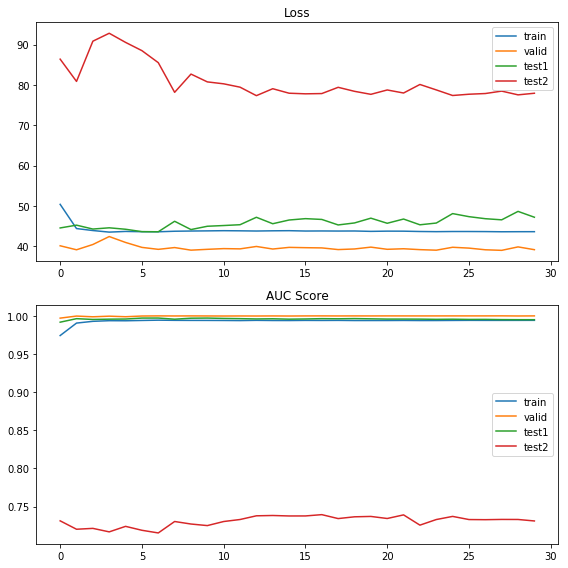

In [37]:
save = "baseline_0.67"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

plt.figure(figsize=(8,8))

plt.subplot(211)
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()


plt.subplot(212)
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
plt.tight_layout()

# if save:
#     path = os.path.join("output", save+'.png')
#     plt.savefig(path)
plt.show()

# Adversarial training

In [40]:
class mydata2(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

UNKId = words_dict['<UNKNOWN>']
word_mal_ratio['<UNKNOWN>'] = 0.5
char_mal_ratio['<UNKNOWN>'] = 0.5
# data = list(map(lambda x:words_dict.get(x, UNKId), word_mal_ratio.keys()))
# label = list(map(lambda x:np.array([x, 1-x]), word_mal_ratio.values()))
data = list(words_dict.values())
label = list(map(lambda x:np.array([word_mal_ratio[x], 1-word_mal_ratio[x]]), words_dict.keys()))

emb_ratio_dataset = mydata2(data, label)
emb_ratio_loader = DataLoader(emb_ratio_dataset, batch_size=batch_size, shuffle=True)

In [41]:
weight = np.zeros((len(words_dict)+1, 2))
for i in words_dict:
    word = i
    idx = words_dict[i]
    ratio = word_mal_ratio[i]
    if np.isnan(ratio):
        ratio = 0.5
    weight[idx] = [ratio, 1-ratio]

In [42]:
d, l = next(iter(emb_ratio_loader))
d.unsqueeze(1).shape

torch.Size([128, 1])

In [43]:
def soft_cross_entropy(inp, target, size_average=True):
    if size_average:
        return torch.mean(torch.sum(-target * F.log_softmax(inp), dim=1))
    else:
        return torch.sum(torch.sum(-target * F.log_softmax(inp), dim=1))

def NegativeEntropyLoss(x):
    b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
    b = b.mean()
    return b

def special_loss(target):
    target = F.softmax(target, dim=1)
    return torch.mean(torch.sum(target*torch.log(target), 1))


def correlation_loss(target, label):
    vx = target - torch.mean(target)
    vy = label - torch.mean(label)
    corr = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    corr = torch.clamp(corr, min=-1.0, max=1.0)
    return corr**2

In [53]:
def adv_step(model, optimizer, loader, train=True, message=""):
    loss_total = 0
    bias_loss_total = 0
    all_logits = []
    all_labels = []
    
    model.train() if train else model.eval()
    bias_model.train if train else bias_model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    
    with mode():
        for (word, char, pad, char_seq, label) in tqdm(loader, desc=message):
            word = word.long().cuda()
            char = char.long().cuda()
            char_seq = char_seq.long().cuda()
            label = label.long().cuda()
            pad = pad.float().cuda()
            
            logits = model(word, char, pad, char_seq).squeeze()
            loss = F.cross_entropy(F.softmax(logits, dim=1), label, reduction="sum")
            
#         for (data, label) in loader:
#             data, label = data.long().to(device), label.long().to(device) # bce:float ce:long
#             logits = model(data).squeeze()
#             loss = F.cross_entropy(F.softmax(logits, dim=1), label, reduction="sum")
            
            ##### uniform
#             _lambda = 0.01
#             out = bias_model(data)
#             loss_bias = NegativeEntropyLoss(out)
#             loss += loss_bias*_lambda
            
            if train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            
            loss_total += loss.item()
            all_labels.append(label.detach().cpu().numpy())
            tmp = F.softmax(logits, dim=1).detach().cpu().numpy()[:, 1]
            all_logits.append(tmp)
            
            
            
            
#             bias_loss_total += emb_step(bias_model, bias_optimizer, train, 1)
            x = bias_model.data2label(word)
            bias_labels = x.flatten(0, 1)
            bias_logits = bias_model(word)
            bias_loss = correlation_loss(bias_logits, bias_labels)
            if train:
                bias_loss.backward()
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                bias_optimizer.step()
                bias_optimizer.zero_grad()
            bias_loss_total += bias_loss.item()
            
                
            

    
    loss_total /= len(loader)
    all_labels = np.hstack(all_labels)
    all_logits = np.hstack(all_logits)
    auc = roc_auc_score(all_labels, all_logits) if len(np.unique(all_labels)) > 1 else 0
    acc = accuracy_thresh_score(all_labels, all_logits)
    bacc = balanced_accuracy_score(all_labels, (all_logits>0.5).astype(int))
    (tn, fp, fn, tp) = confusion_matrix(all_labels, (all_logits>0.5).astype(int)).ravel()


    bias_loss_total = bias_loss_total/len(loader)

#     logger.info('Loss       : {}'.format(loss_total))
#     logger.info('Bias Loss  : {}'.format(bias_loss_total))
#     logger.info('Accuracy   : {}'.format(acc))
#     logger.info('balance Acc: {}'.format(bacc))
#     logger.info('AUC        : {}'.format(auc))
#     logger.info('confusion  : {}'.format((tn, fp, fn, tp)))
    
    return {'loss':loss_total, 'acc':acc, 'auc':auc, "bias":bias_loss_total}

In [54]:
def emb_step(model, optimizer, train=False, iters=1):
    loader = emb_ratio_loader
    loss_total = 0
    entropy_loss = 0
    
    model.train() if train else model.eval()
    mode = torch.enable_grad if train else torch.no_grad
    with mode():
        for _ in range(iters):
            for (data, label) in loader:
                data, label = data.long().unsqueeze(1).to(device), label.float().to(device)
                logits = model(data)
                #loss = F.mse_loss(logits, label, reduction="sum") * 0.1
                #loss = soft_cross_entropy(logits, label, size_average=False)
                loss = correlation_loss(logits, label)
                #loss = F.kl_div(logits, label, reduction='sum')
                #loss = NegativeEntropyLoss(logits)
                
                if train:
                    loss.backward()
                    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()
                loss_total += loss.item()

    loss_total /= (len(loader)*iters)
    return loss_total#, entropy_loss

In [55]:
# test loss function

class BiasPredictor(nn.Module):
    def __init__(self, emb, emb_size, word_mal_ratio, hidden_size=32, num_classes=2):
        super(BiasPredictor, self).__init__()
        self.emb = emb
        self.fc1 = nn.Linear(emb_size, num_classes)
        self.data2label = nn.Embedding(len(words_dict)+1, 2)
        
        weight = np.zeros((len(words_dict)+1, 2))
        for i in words_dict:
            word = i
            idx = words_dict[i]
            ratio = word_mal_ratio[i]
            if np.isnan(ratio):
                ratio = 0.5
            weight[idx] = [ratio, 1-ratio]
        self.data2label.weight.data.copy_(torch.from_numpy(weight))
        self.data2label.weight.requires_grad = False
        

    def forward(self, x):
        x = self.emb(x)
        x = models.grad_reverse(x)
        x = x.flatten(0, 1)
        logits = self.fc1(x)
        return logits

# adv_model = models.WordCNN(
#             word_ngram_vocab_size = len(words_dict)+1,
#             emb_size=emb_dim,
#             word_seq_len=max_len_words,
#             l2_reg_lambda=l2_reg_lambda,
#             kernel_sizes=filter_size).cuda()
# adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=1e-3)

# bias_model = BiasPredictor(adv_model.word_emb, emb_dim).cuda()
# bias_optimizer = torch.optim.Adam(bias_model.parameters(), lr=1e-3)

# for i in range(10):
#     bias_loss = emb_step(bias_model, bias_optimizer, True, 10)
#     print(bias_loss)
#     print(F.softmax(bias_model(d.long().unsqueeze(1).cuda()), dim=1)[:8])
    
# #print(F.softmax(bias_model(d.long().unsqueeze(1).cuda()), dim=1)[:8])
# print(l[:8])

In [56]:
best = []
def adv_train(history, epochs):
    for e in tqdm(range(epochs), desc="Epoch"):
        train_result = adv_step(adv_model, adv_optimizer, train_loader, train=True, message="Training :{}".format(e))
        valid_result = adv_step(adv_model, adv_optimizer, val_loader, train=False, message="Validation :{}".format(e))
        test_result1 = adv_step(adv_model, adv_optimizer, test_loader1, train=False, message="Test 1 :{}".format(e))
        test_result2 = adv_step(adv_model, adv_optimizer, test_loader2, train=False, message="Test 2 :{}".format(e))

        history['train'].append(train_result)
        history['valid'].append(valid_result)
        history['test1'].append(test_result1)
        history['test2'].append(test_result2)
    return history

for i in range(1):
    set_seed(87+i)
    adv_model = models.TextCNN(
            word_ngram_vocab_size = len(words_dict)+1,
            char_ngram_vocab_size = len(ngrams_dict)+1,
            char_vocab_size = len(chars_dict)+1,
            emb_size=emb_dim,
            char_seq_len = max_len_chars,
            word_seq_len=max_len_words,
            l2_reg_lambda=l2_reg_lambda,
            dropout=0.2,
            kernel_sizes=filter_size).cuda()
    adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=1e-3, weight_decay=1)

    bias_model = BiasPredictor(adv_model.word_emb, emb_dim, word_mal_ratio).to(device)
    #bias_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, bias_model.parameters()), lr=0.1)
    bias_optimizer = torch.optim.Adam(bias_model.parameters(), lr=0.1)
    
    history = {'train':[], 'valid':[], 'test1':[], 'test2':[]}
    history = adv_train(history, 30)
    best.append(max([i['auc'] for i in history['test2']]))

print(best)
print(np.mean(best))
best2 = np.mean(best)



[0.8725074624731007]
0.8725074624731007


In [ ]:
history = adv_train(history, 100)
max([i['auc'] for i in history['test2']])

### no reverse grad + loss = -1.0 * corr

* dev 0.9 min 0
    * 0.730, 0.901
* dev 0.9 min 10
    * 0.726, 0.870
* dev 0.9 min 20
    * 0.679, 0.862
* dev 0.9 min 30
    * 0.695, 0.865


* dev 0.5, min 1
    * 0.714, 0.731
* dev 0.5, min 0
    * 0.728, 0.843
* dev 0.5, min 10
    * 0.699, 0.878
* dev 0.5, min 20
    * 0.671, 0.845
* dev 0.5, min 30
    * 0.702, 0.867


* dev 0.01, min 0
    * 0.723, 0.844
* dev 0.01, min 5
    * 0.702, 0.779
* dev 0.01, min 20
    * 0.673, 0.906
* dev 0.01, min 30
    * 0.700, 0.867
* dev 0.01, min 10
    * 0.706, 0.890

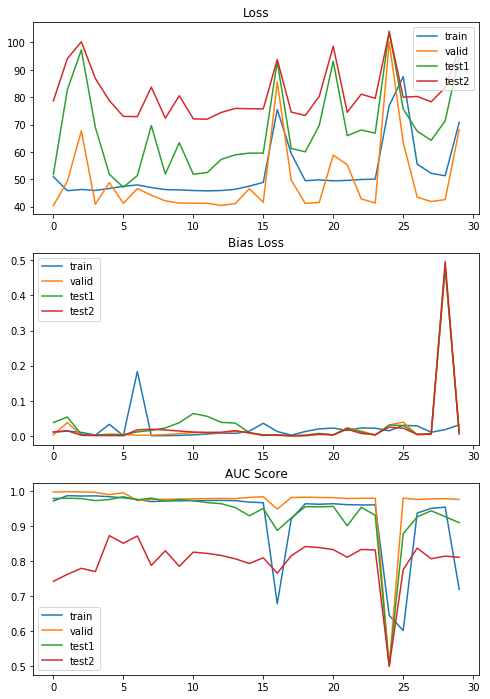

In [57]:
save = "adv_max_corr"

train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
test1_loss = [l['loss'] for l in history['test1']]
test2_loss = [l['loss'] for l in history['test2']]

train_bloss = [l['bias'] for l in history['train']]
valid_bloss = [l['bias'] for l in history['valid']]
test1_bloss = [l['bias'] for l in history['test1']]
test2_bloss = [l['bias'] for l in history['test2']]

train_auc = [l['auc'] for l in history['train']]
valid_auc = [l['auc'] for l in history['valid']]
test1_auc = [l['auc'] for l in history['test1']]
test2_auc = [l['auc'] for l in history['test2']]

plt.figure(figsize=(8,12))

plt.subplot(311)
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.plot(test1_loss, label='test1')
plt.plot(test2_loss, label='test2')
plt.legend()


plt.subplot(312)
plt.title('Bias Loss')
plt.plot(train_bloss, label='train')
plt.plot(valid_bloss, label='valid')
plt.plot(test1_bloss, label='test1')
plt.plot(test2_bloss, label='test2')
plt.legend()


plt.subplot(313)
plt.title('AUC Score')
plt.plot(train_auc, label='train')
plt.plot(valid_auc, label='valid')
plt.plot(test1_auc, label='test1')
plt.plot(test2_auc, label='test2')
plt.legend()
# if save:
#     path = os.path.join("output", save+'.png')
#     plt.savefig(path)
plt.show()

In [ ]:
print(time.time()-st)